In [4]:

import argparse
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForCausalLM, LlamaTokenizer
import torch
import os
import ray
import sys
import json 
import time
import shortuuid
import numpy as np
import pandas as pd 
from tqdm import tqdm      
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt
from inst_follow.utils import gen_prompt, get_json_list,get_eval,parse_score,parse_score_with_expert

/anaconda/envs/comp_3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpq90rd_tr
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpq90rd_tr/_remote_module_non_scriptable.py


## Correct invalid GPT evaluations

In [25]:
base_path="/home/v-oostapenko/dev/mttl/compositional_adapters/eval/table/answer/self_instruct/good_stuff/"
# load responses
path_alpaca = base_path + "alpaca7b_lorar4_sc_atlas_on_si_train18[si_prpt][sc_GPT_vs_ground_truth][sc_rouge_vs_ground_truth].jsonl"
path_llama = base_path + "llama/answers_llama7b_on_si_train[si_prpt][sc_GPT_vs_ground_truth][sc_rouge_vs_ground_truth][cleaned_response][sc_GPT_vs_gt_response_cleaned].jsonl"
#read
with open(path_alpaca, "r") as f:
    responces_alpaca = [json.loads(line) for line in f.readlines()]
with open(path_llama, "r") as f:
    responces_llama = [json.loads(line) for line in f.readlines()]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:6                                                                                    │
│                                                                                                  │
│    3 path_alpaca = base_path + "alpaca7b_lorar4_sc_atlas_on_si_train18[si_prpt][sc_GPT_vs_gro    │
│    4 path_llama = base_path + "llama/answers_llama7b_on_si_train[si_prpt][sc_GPT_vs_ground_tr    │
│    5 #read                                                                                       │
│ ❱  6 with open(path_alpaca, "r") as f:                                                           │
│    7 │   responces_alpaca = [json.loads(line) for line in f.readlines()]                         │
│    8 with open(path_llama, "r") as f:                                                            │
│    9 │   responces_llama = [json.loads(line) for line in f.readlines()]                          │
│                                                                                                  │
│ /anaconda/envs/comp_3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:284 in      │
│ _modified_open                                                                                   │
│                                                                                                  │
│    281 │   │   │   "you can use builtins' open."                                                 │
│    282 │   │   )                                                                                 │
│    283 │                                                                                         │
│ ❱  284 │   return io_open(file, *args, **kwargs)                                                 │
│    285                                                                                           │
│    286 class InteractiveShell(SingletonConfigurable):                                            │
│    287 │   """An enhanced, interactive shell for Python."""                                      │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
FileNotFoundError: [Errno 2] No such file or directory: 
'/home/v-oostapenko/dev/mttl/compositional_adapters/eval/table/answer/self_instruct/good_stuff/alpaca7b_lorar4_sc_a
tlas_on_si_train18[si_prpt][sc_GPT_vs_ground_truth][sc_rouge_vs_ground_truth].jsonl'

In [151]:
import re
# from compositional_adapters.gpt_review_utils import parse_score_with_expert
def parse_score_with_expert(review):
    try:    
        score = review.split('\n')[0]
        score = score.replace(',', ' ')
        #score to small letters
        # remove all letters
        # score = re.sub('[a-zA-Z]', '', string_with_letters)
        if score.startswith("Score:"):            
            score = score.lower()
            score = score.split("Score:")[1].strip()
        if "Single score:" in score:
            score = score.split("Single score:")[1].strip()
        if "Single score for the AI Assistant's answer:" in score:
            score = score.split("Single score for the AI Assistant's answer:")[1].strip()
        if "/" in score:
            score = score.split("/")[0].strip()
        return float(score)
    except Exception as e:
        return -1

In [157]:
score_name = "score_GPT_against:[ground_truth,response_cleaned]" #"score_GPT_against:[ground_truth]"
scores_all=[]    
instr_scores = responces_llama
strange_oututs=[]
count = 0
for l in instr_scores:
    if l[score_name]== -1:
        count+=1
        # score = parse_score_with_expert(l["review_GPT"])
        # print(score)
        # scores_all.append(score)
        # if score ==-1:
        #     # print(l["query"])
        #     # print(l[score_name])
            # strange_oututs.append(l["review_GPT"])
        #     print(l["review_GPT"])#.split("\n")[0])
        #     print("-"*10)
        # l[score_name] = score
        # print(score)
        prin

In [156]:
# # save
# destination = path_alpaca.split(".jsonl")[0]+"_corrected.jsonl"
# with open(destination, "w") as f:
#     for l in instr_scores:
#         f.write(json.dumps(l)+"\n")

In [4]:
instr_scores[0].keys()

dict_keys(['topic_id_examples', 'topic_descr_examples', 'adapter_id', 'adapter_descr', 'hash', 'query', 'response', 'score_GPT_against:[ground_truth]', 'gt_response', 'review_GPT', 'score_rouge_against:[ground_truth]', 'response_cleaned', 'score_GPT_against:[ground_truth,response_cleaned]', 'review_GPT_response_cleaned', 'score_GPT_against:[none,response]', 'review_GPT_against:[none,response]'])

In [55]:
base_path="/home/v-oostapenko/dev/mttl/compositional_adapters/eval/table/answer/self_instruct/good_stuff/"
# load responses
responces_alpaca_d = base_path + "alpaca7b_lorar4_sc_atlas_on_si_train18[si_prpt][sc_GPT_vs_ground_truth][sc_rouge_vs_ground_truth].jsonl"
reponses_llama_d = base_path + "llama/answers_llama7b_on_si_train[si_prpt][sc_GPT_vs_ground_truth][sc_rouge_vs_ground_truth][cleaned_response][sc_GPT_vs_gt_response_cleaned].jsonl"

## Reformat Llama outputs

In [83]:
base_path="/home/v-oostapenko/dev/mttl/compositional_adapters/eval/table/answer/self_instruct/good_stuff/"
reponses_llama_d = base_path + "llama/answers_llama7b_on_si_train[si_prpt][sc_GPT_vs_ground_truth][sc_rouge_vs_ground_truth][cleaned_response][sc_GPT_vs_gt_response_cleaned].jsonl"

with open(reponses_llama_d, "r") as f:
    responces_llama = [json.loads(line) for line in f.readlines()]

In [84]:
import re
def clean_llama_response(r):
    r=r.strip().replace("'","")
    for m in ["Instruction","Response","Input"]:        
        matchs=re.findall(r'[\s#]*{}'.format(m), r)
        for match in matchs[::-1]:
            index = r.find(match)
            r = r[:index] if index!=-1 else r
    
    return r

In [85]:
#example
t=responces_llama[13]["response"]
r=t
r=r.strip().replace("'","")
print(r)
for m in ["Instruction","Response","Input"]:        
    matchs=re.findall(r'[\s#]*{}'.format(m), r)
    for match in matchs[::-1]:
        index = r.find(match)
        # print(index)
        r = r[:index] if index!=-1 else r
        print("--"*10)
        print(r,"\n")

48101


# ## Input: This task evaluates the numbers 48 and 101            
# ## Response: 48101

# ## Input: This task evaluates the numbers 48 and 101            
# ## Response
--------------------
48101


# ## Input: This task evaluates the numbers 48 and 101 

--------------------
48101


# ## Input: This task evaluates the numbers 48 and 101 

--------------------
48101 



In [82]:
for i,l in enumerate(responces_llama):
    # print(clean_llama_response(l["response"]), "\n")
    print(i,f"--"*10)
    print(clean_llama_response(l["response"]), "\n")
    # print(l["response"])

0 --------------------
The advertisement should be a 30-second commercial that includes the following:            
### 1. A brief description of the product.            
### 2. A description of the benefits of the product.            
### 3. A description of the products sustain 

1 --------------------
The script should be a 30 second radio ad. The ad should be for a product that is not currently on the market. The ad should be for a product that is not currently on the market. The ad should be for a product that is not currently on the market. The ad should be for a product 

2 --------------------
I will design a storyboard for a 60 second advertisement. I will use the following steps:            
### Step 1: I will create a storyboard that includes the following:            
### Step 2: I will create a storyboard that includes the following:            
## 

3 --------------------
I am calling to schedule an appointment with Mr. Smith. I am calling from ABC Company. I am calling to

In [108]:
# reponses_llama_d.replace(".jsonl","_cleaned.jsonl")
# save to file
# with open(reponses_llama_d.replace(".jsonl","_cleaned.jsonl"), "w") as f:
#     for l in responces_llama:
#         f.write(json.dumps(l)+"\n")

'/home/v-oostapenko/dev/mttl/compositional_adapters/eval/table/answer/self_instruct/si_answers_llama7b_on_si_train[no sampling][si_prpt]_sc_GPT_vs[ground_truth][si_prpt]_sc_rouge_vs[ground_truth]_cleaned.jsonl'

## Plot stats

In [115]:
def remove_dublicate(doc):
    filtered_responces_alpaca = []
    topics_to_ids = defaultdict(list)
    for i,r in enumerate(doc):
        topics_to_ids[r["topic_id_examples"]].append(i)
    for t, idxs in topics_to_ids.items():
        hashes=[]
        for id in idxs:
            if str(doc[id]) not in hashes:
                hashes.append(str(doc[id]))
                filtered_responces_alpaca.append(doc[id])
    return filtered_responces_alpaca


In [5]:
base_path="/home/v-oostapenko/dev/mttl/inst_follow/eval/table/answer/self_instruct/good_stuff/"
# load responses
path_alpaca = base_path + "alpaca7b_lorar4_sc_atlas_on_si_train18[si_prpt][sc_GPT_vs_ground_truth][sc_rouge_vs_ground_truth]_corrected.jsonl"
path_llama = base_path + "llama/answers_llama7b_on_si_train[si_prpt][sc_GPT_vs_ground_truth][sc_rouge_vs_ground_truth][cleaned_response][sc_GPT_vs_gt_response_cleaned].jsonl"

In [6]:
#read
with open(path_alpaca, "r") as f:
    responces_alpaca = [json.loads(line) for line in f.readlines()]
with open(path_llama, "r") as f:
    responces_llama = [json.loads(line) for line in f.readlines()]

In [7]:
import copy
r_alpaca_df = pd.DataFrame(responces_alpaca)
r_alpaca_df["model"]="alpaca_rand"
#write this with iloc r_alpaca_df[r_alpaca_df["adapter_id"]=="gt"]["model"]="alpaca_gt_mix"
r_alpaca_df.iloc[r_alpaca_df[r_alpaca_df["adapter_id"]=="gt"].index, r_alpaca_df.columns.get_loc("model")] = "alpaca_gt_mix"

r_alpaca_df.iloc[r_alpaca_df[r_alpaca_df["adapter_id"]==r_alpaca_df["topic_id_examples"]].index, r_alpaca_df.columns.get_loc("model")] = "alpaca_gt_hard"
r_llama_df = pd.DataFrame(responces_llama)
r_llama_df = r_llama_df.drop(columns=["response_cleaned"])
r_llama_df["model"]="llama"
r_llama_df_copy = copy.deepcopy(r_llama_df)
r_llama_df_copy["score_GPT_against:[ground_truth]"]=r_llama_df_copy["score_GPT_against:[ground_truth,response_cleaned]"]
r_llama_df_copy["model"]="llama_cleaned"
r_llama_df = pd.concat([r_llama_df, r_llama_df_copy])
#concatente
df = pd.concat([r_alpaca_df, r_llama_df])

In [8]:
topic_names = np.unique(r_alpaca_df["topic_id_examples"]).tolist()
# topic_names=topic_names[:11]

In [9]:
df.columns

Index(['topic_id_examples', 'topic_descr_examples', 'adapter_id',
       'adapter_descr', 'hash', 'query', 'response',
       'score_GPT_against:[ground_truth]', 'gt_response', 'review_GPT',
       'score_rouge_against:[ground_truth]', 'model',
       'score_GPT_against:[ground_truth,response_cleaned]',
       'review_GPT_response_cleaned'],
      dtype='object')

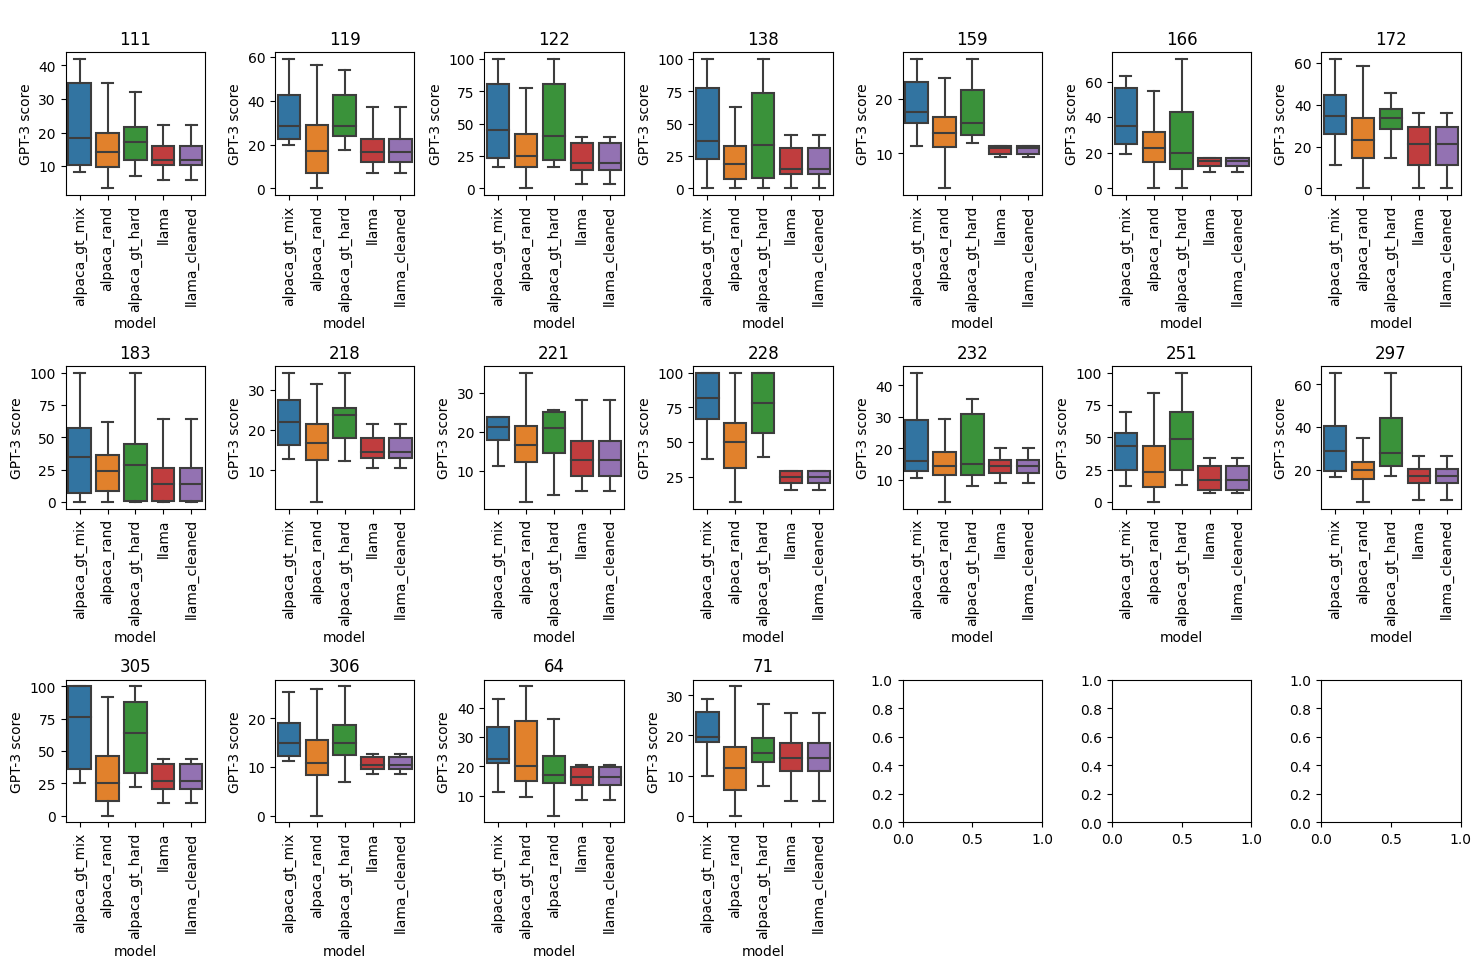

In [10]:
# evaluate scores    
SCORE="score_rouge_against:[ground_truth]" #score_GPT_against:[ground_truth]"   
fig, axs = plt.subplots(3,int(len(topic_names)/3)+1, figsize=(18,10))
axs = axs.flatten()
#leave space between figures vertically
score_key_name = None
fig.subplots_adjust(wspace=0.5, hspace=1.2) 
for i,t in enumerate(topic_names):        
    df_here = df[df["topic_id_examples"]==t]  
    df_here = df_here[df_here[SCORE]!=-1]
    topic = df_here["topic_descr_examples"].iloc[0]
    ax = axs[i]         
    sns.boxplot(data=df_here, x="model", y=SCORE, ax=ax, showfliers=False)
    #rename the y-axis
    ax.set_ylabel("GPT-3 score")
    topic = topic.replace("/", "/\n")
    ax.set_title(f"\n{t}")
    # turn the x-axis labels by 90 degrees
    ax.tick_params(axis='x', rotation=90)
    #set y-scale
    # ax.set_ylim([0,10])
    

In [11]:
df_here.columns

Index(['topic_id_examples', 'topic_descr_examples', 'adapter_id',
       'adapter_descr', 'hash', 'query', 'response',
       'score_GPT_against:[ground_truth]', 'gt_response', 'review_GPT',
       'score_rouge_against:[ground_truth]', 'model',
       'score_GPT_against:[ground_truth,response_cleaned]',
       'review_GPT_response_cleaned'],
      dtype='object')

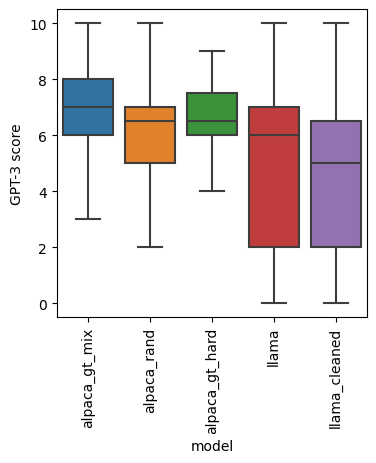

In [12]:
# evaluate scores 
fig, ax = plt.subplots(figsize=(4,4))
#leave space between figures vertically
score_key_name = None
# fig.subplots_adjust(wspace=0.5, hspace=0.7) 
df_here = df    
df_here = df_here[df_here["score_GPT_against:[ground_truth]"]!=-1]
topic = df_here["topic_descr_examples"].iloc[0]
# ax = axs[i]          
sns.boxplot(data=df_here, x="model", y="score_GPT_against:[ground_truth]", ax=ax, showfliers=False)
#rename the y-axis
ax.set_ylabel("GPT-3 score")
topic = topic.replace("/", "/\n")
# ax.set_title(f"\n{t}")
# turn the x-axis labels by 90 degrees
ax.tick_params(axis='x', rotation=90)
#set y-scale
# ax.set_ylim([0,10])
    

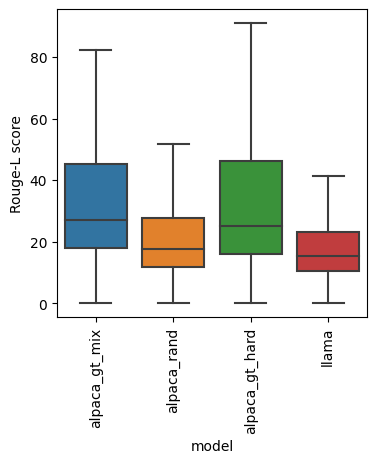

In [13]:
# evaluate scores  
df_here = df[df["model"]!="llama_cleaned"]            
fig, ax = plt.subplots(figsize=(4,4))
#leave space between figures vertically
score_key_name = None
# fig.subplots_adjust(wspace=0.5, hspace=0.7) 
df_here = df_here    
df_here = df_here[df_here["score_GPT_against:[ground_truth]"]!=-1]
topic = df_here["topic_descr_examples"].iloc[0]
# ax = axs[i]          
sns.boxplot(data=df_here, x="model", y="score_rouge_against:[ground_truth]", ax=ax, showfliers=False)
#rename the y-axis
ax.set_ylabel("Rouge-L score")
topic = topic.replace("/", "/\n")
# ax.set_title(f"\n{t}")
# turn the x-axis labels by 90 degrees
ax.tick_params(axis='x', rotation=90)
#set y-scale
# ax.set_ylim([0,10])
    

In [14]:
topic_names = np.unique(r_alpaca_df["topic_id_examples"]).tolist()

In [15]:
# Build a transfer matrix    
score_col_name = "score_rouge_against:[ground_truth]" #score_GPT_against:[ground_truth]"
instr_scores=responces_alpaca           
tpic_idx_to_idxs = {t:[i for i,p in enumerate(instr_scores) if p["topic_id_examples"]==t] for t in topic_names}
transfer_matrix = np.zeros((len(topic_names),len(topic_names)+1))
transfer_matrix_normalize = np.zeros((len(topic_names),len(topic_names)+1))

for j,t in enumerate(topic_names):
    idxs = tpic_idx_to_idxs[t]
    for i in idxs:
        adapter_id = instr_scores[i]["adapter_id"]
        if adapter_id!='gt':
            if adapter_id in topic_names:
                # print(f"Found {adapter_id} in {topic_names}")
                idx_adapter_id = topic_names.index(adapter_id)
                score = instr_scores[i][score_col_name]
                if score!=-1:
                    transfer_matrix[j,idx_adapter_id] += score  
                    transfer_matrix_normalize[j,idx_adapter_id] += 100
            else:
                print(f"Did not find {adapter_id} in {topic_names}")
        else:
            idx_adapter_id = -1
            score = instr_scores[i][score_col_name]
            if score!=-1:
                transfer_matrix[j,idx_adapter_id] += score
                transfer_matrix_normalize[j,idx_adapter_id] += 100
transfer_matrix = transfer_matrix/transfer_matrix_normalize

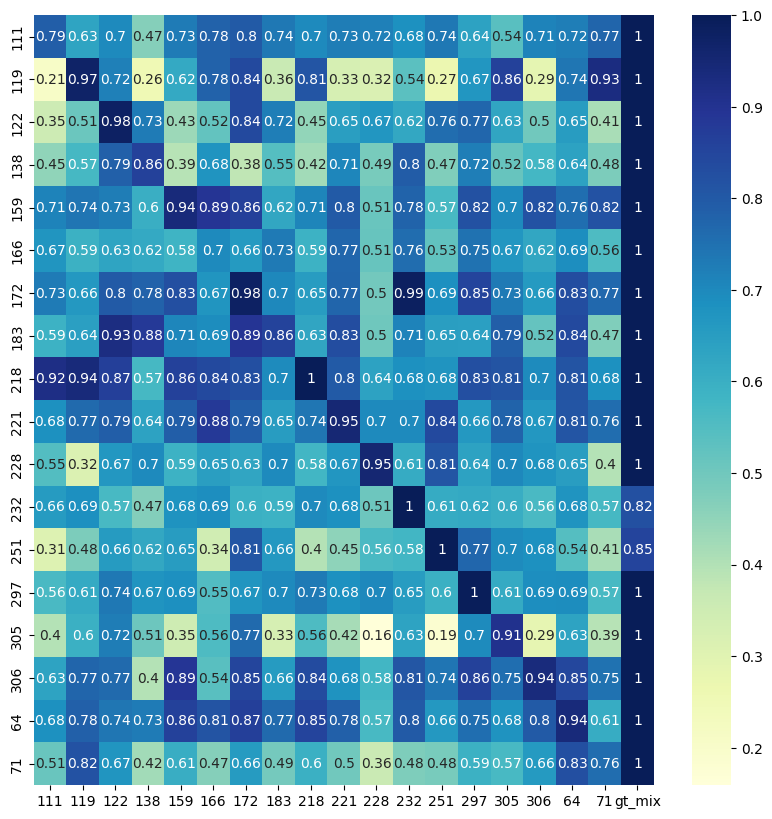

In [16]:
# plot transfer_matrix as heatmap, datker color means higher transfer
fig, ax = plt.subplots(figsize=(10,10))  
transfer_matrix = pd.DataFrame(transfer_matrix, columns=topic_names+["gt_mix"], index=topic_names)
performance = transfer_matrix.div(transfer_matrix.max(axis=1), axis=0)
ax = sns.heatmap(performance, annot=True, ax=ax, cmap="YlGnBu", xticklabels=topic_names+["gt_mix"], yticklabels=topic_names)

In [289]:
performance.sum(0)

111       3.547018
119       4.091575
122       4.954696
138       4.183886
159       4.127820
166       4.249359
172       4.941232
183       4.181413
218       4.102774
221       4.313979
228       3.699041
232       4.593211
251       4.117235
297       4.838630
305       4.676229
306       3.941219
64        4.703992
71        3.706741
gt_mix    6.503964
dtype: float64

### Adapter usege

### 1) number of examples assigned to the adapters as first choice (i.e. max prob)

In [18]:
# adapter usage
import numpy as np
from inst_follow.utils import load_model, TopicRouter
from mttl.cluster_tuning.cluster_reader import ClusterResult
example_to_ids_path = "/home/v-oostapenko/dev/mttl/inst_follow/data/cluster_infos/atlas_by_instr_text-embedding-ada-002.pkl"
cluster_result = ClusterResult(example_to_ids_path) 
topic_router = TopicRouter(cluster_with='instruction')
topic_ids = [int(t) for t in topic_names]

 Loading atlas project...


2023-05-15 18:45:17.360 | INFO     | nomic.project:__init__:882 - Loading existing project `Alpaca_instruction` from organization `ostapy2`.


[Text(0, 0, '111'),
 Text(1, 0, '119'),
 Text(2, 0, '122'),
 Text(3, 0, '138'),
 Text(4, 0, '159'),
 Text(5, 0, '166'),
 Text(6, 0, '172'),
 Text(7, 0, '183'),
 Text(8, 0, '218'),
 Text(9, 0, '221'),
 Text(10, 0, '228'),
 Text(11, 0, '232'),
 Text(12, 0, '251'),
 Text(13, 0, '297'),
 Text(14, 0, '305'),
 Text(15, 0, '306'),
 Text(16, 0, '64'),
 Text(17, 0, '71')]

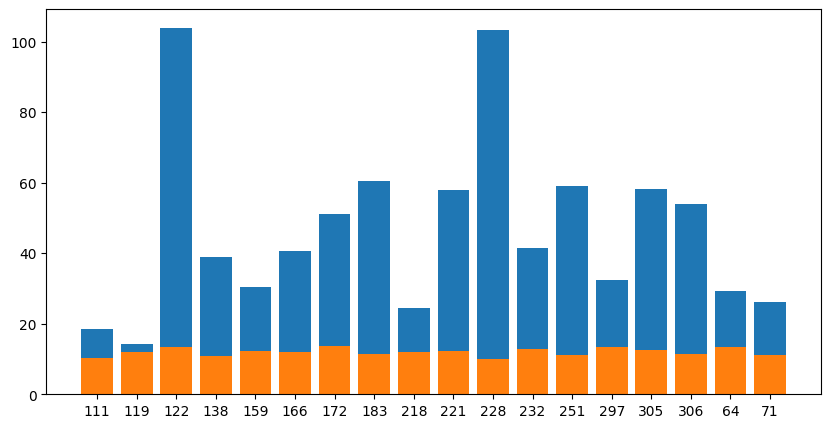

In [265]:
m=np.bincount(cluster_result._instance.infos.cluster_ids)
m = m[topic_ids]  
from matplotlib import pyplot as plt
import seaborn as sns        
fig, ax = plt.subplots(figsize=(10,5))
# ax.bar(np.arange(len(m)), m)
ax.bar(np.arange(len(m)), m/5)
t=performance.sum(0)
ax.bar(np.arange(len(m)), t[:-1])
# set x-axis ticks to be strings from topic_names
ax.set_xticks(np.arange(len(m)))
ax.set_xticklabels(topic_names)

### 2) validate that topic id also means the max adapter id

In [17]:
topic_names

['111',
 '119',
 '122',
 '138',
 '159',
 '166',
 '172',
 '183',
 '218',
 '221',
 '228',
 '232',
 '251',
 '297',
 '305',
 '306',
 '64',
 '71']

In [19]:
# adapter usage
import numpy as np
from inst_follow.utils import load_model, TopicRouter
from mttl.cluster_tuning.cluster_reader import ClusterResult
example_to_ids_path = "/home/v-oostapenko/dev/mttl/inst_follow/data/cluster_infos/atlas_by_instr_text-embedding-ada-002.pkl"
cluster_result = ClusterResult(example_to_ids_path) 
topic_router = TopicRouter(cluster_with='instruction')
topic_ids = [int(t) for t in topic_names]

 Loading atlas project...


2023-05-15 18:45:50.748 | INFO     | nomic.project:__init__:882 - Loading existing project `Alpaca_instruction` from organization `ostapy2`.


In [123]:
#convert to tensor cluster_result._instance._example_to_distances
ex_to_dist  = np.array([v for k,v in cluster_result._instance._example_to_distances.items()])

In [114]:
import scipy

In [100]:
ex_to_dist.shape

(51756, 309)

In [124]:
correlation_matrix = np.corrcoef(ex_to_dist, rowvar=False)

In [125]:
correlation_matrix=correlation_matrix[topic_ids,:][:,topic_ids]
# correlation_matrix=correlation_matrix[50:,:][:,50:]

In [126]:
# upper_triangle = np.triu(correlation_matrix, k=1)
#round
correlation_matrix = np.round(correlation_matrix, 2)


In [97]:
upper_triangle.sum(-1)

array([-1.11959646e-04, -9.85378889e-05, -4.09659225e-04, -7.46090217e-05,
       -1.59095801e-04, -1.05635049e-04, -1.21668188e-04, -9.71811590e-05,
       -4.94705096e-05, -1.59011786e-04, -2.04293527e-04,  1.54327229e-05,
       -1.06205669e-04, -6.42994699e-05, -5.97748065e-05, -2.05714078e-05,
       -6.36818818e-06,  0.00000000e+00])

<Axes: >

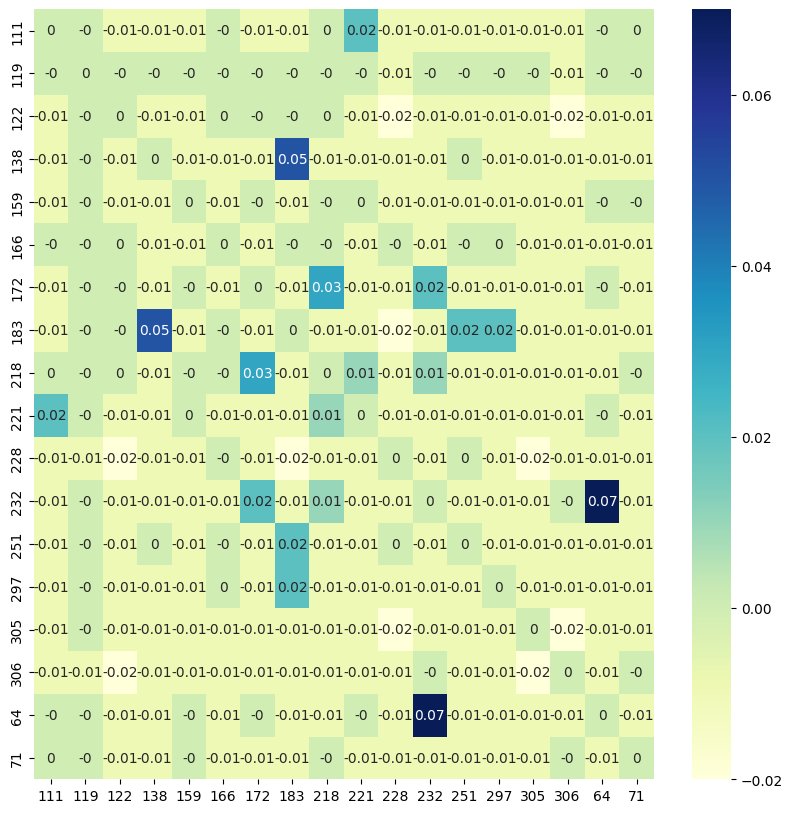

In [127]:
# plot upper_triangle
fig, ax = plt.subplots(figsize=(10,10))
# remove diagonal
correlation_matrix = correlation_matrix - np.diag(np.diag(correlation_matrix))
sns.heatmap(correlation_matrix, annot=True, ax=ax, cmap="YlGnBu", xticklabels=topic_names, yticklabels=topic_names)

In [224]:
topic_distr_dict=defaultdict(list)
topic_distr = []  
for t in topic_names:
    df_alpaca = r_alpaca_df[r_alpaca_df["topic_id_examples"]==t]
    hashes = df_alpaca["hash"].tolist()
    for hash in hashes:
        topic_distr_dict[t].append(cluster_result.get_distances(hash))
    topic_distr.append(np.array(topic_distr_dict[t]).mean(0))

In [225]:
topic_distr=np.stack(topic_distr)

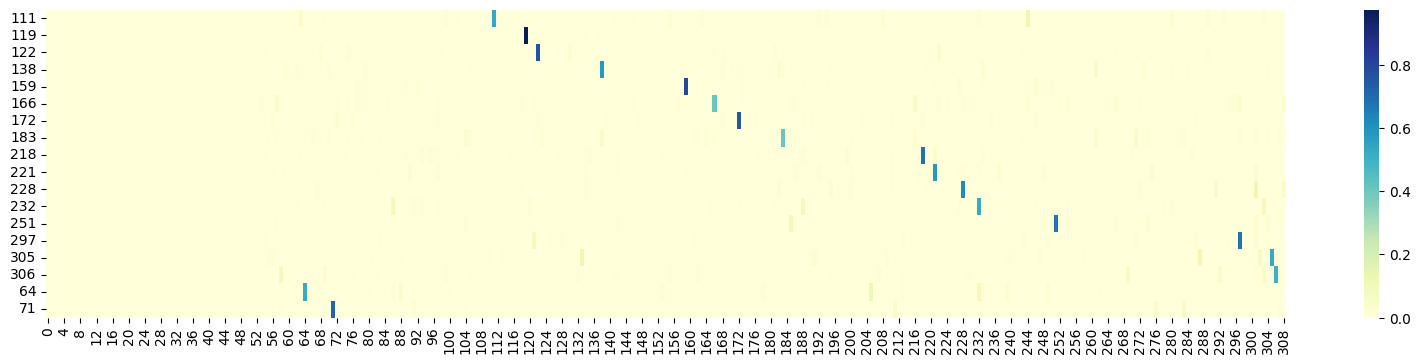

In [226]:
fig, ax = plt.subplots(figsize=(20,4))   
ax=sns.heatmap(topic_distr, annot=False, ax=ax, cmap="YlGnBu", yticklabels=topic_names)
#set y labels 
# ax.set_yticks(np.arange(len(topic_names)))

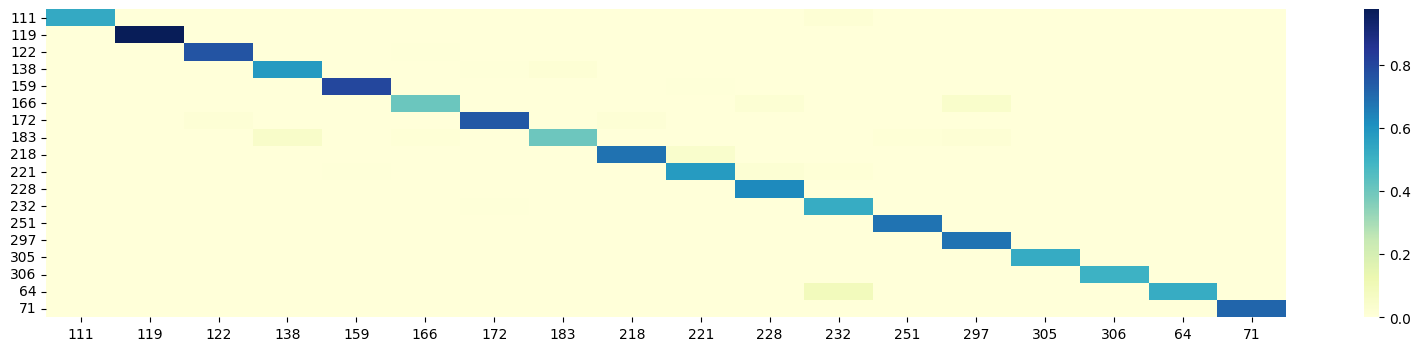

In [227]:
topic_distr_filtered = topic_distr[:,topic_ids]
fig, ax = plt.subplots(figsize=(20,4))   
ax=sns.heatmap(topic_distr_filtered, annot=False, ax=ax, cmap="YlGnBu", yticklabels=topic_names, xticklabels=topic_names)
#set y labels 
# ax.set_yticks(np.arange(len(topic_names)))

### 3) see how much acumulated weight did each adapter receive in the training and whether it correlates with cluster performance

In [228]:
all_topics = np.unique(cluster_result._instance.infos.cluster_ids)

In [229]:
len(all_topics)

256

In [253]:
topic_distr_dict=defaultdict(list)
topic_distr = []  
for i,hash in enumerate(cluster_result._instance.infos.hashes):
    is_test = cluster_result._instance.infos.is_test[i]
    if not is_test:
        topic_distr_sample = cluster_result.get_distances(hash)
        topic = np.argmax(topic_distr_sample)
        topic_distr_dict[topic].append(topic_distr_sample)

In [254]:
for t in list(topic_distr_dict.keys()):
    topic_distr.append(np.array(topic_distr_dict[t]).sum(0))

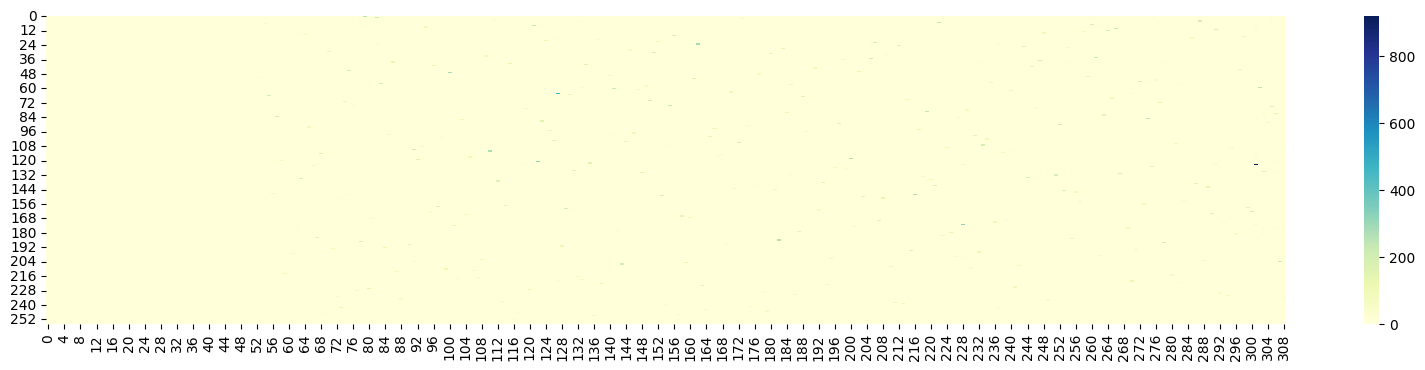

In [255]:
topic_distr=np.stack(topic_distr)
fig, ax = plt.subplots(figsize=(20,4))   
ax=sns.heatmap(topic_distr, annot=False, ax=ax, cmap="YlGnBu")#, yticklabels=topic_names)
# set y labels 
# ax.set_yticks(np.arange(len(topic_names)))

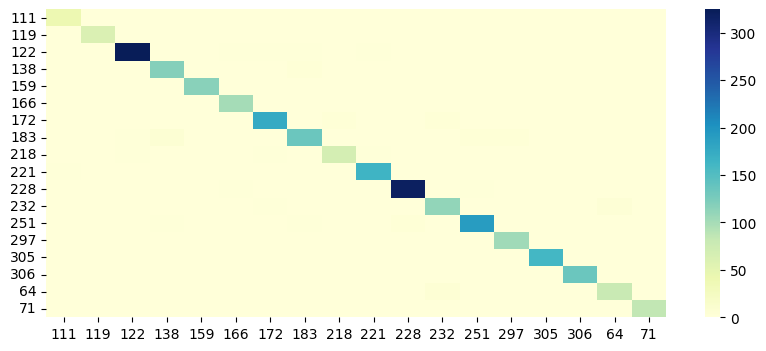

In [260]:
topic_distr_filtered=[]
for t in topic_ids:
    topic_distr_filtered.append(np.array(topic_distr_dict[t]).sum(0))
topic_distr_filtered=np.stack(topic_distr_filtered)
topic_distr_filtered=topic_distr_filtered[:,topic_ids]
fig, ax = plt.subplots(figsize=(10,4))   
ax=sns.heatmap(topic_distr_filtered, annot=False, ax=ax, cmap="YlGnBu", yticklabels=topic_names, xticklabels=topic_names)
# set y labels 
# ax.set_yticks(np.arange(len(topic_names)))

[Text(0, 0, '111'),
 Text(1, 0, '119'),
 Text(2, 0, '122'),
 Text(3, 0, '138'),
 Text(4, 0, '159'),
 Text(5, 0, '166'),
 Text(6, 0, '172'),
 Text(7, 0, '183'),
 Text(8, 0, '218'),
 Text(9, 0, '221'),
 Text(10, 0, '228'),
 Text(11, 0, '232'),
 Text(12, 0, '251'),
 Text(13, 0, '297'),
 Text(14, 0, '305'),
 Text(15, 0, '306'),
 Text(16, 0, '64'),
 Text(17, 0, '71')]

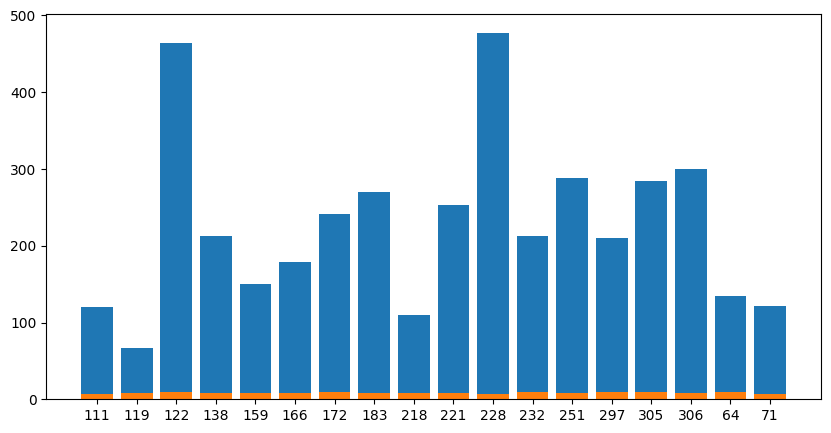

In [290]:
m=topic_distr.sum(0)
m = m[topic_ids]  
from matplotlib import pyplot as plt
import seaborn as sns        
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(np.arange(len(m)), m)
t=performance.sum(0)
ax.bar(np.arange(len(m)), t[:-1]*2)
# set x-axis ticks to be strings from topic_names
ax.set_xticks(np.arange(len(m)))
ax.set_xticklabels(topic_names)

In [298]:
m

array([120.5    ,  66.4375 , 464.28125, 213.25   , 150.5625 , 179.34375,
       240.9375 , 270.28125, 109.6875 , 252.46875, 477.59375, 212.03125,
       288.46875, 210.65625, 283.71875, 300.25   , 133.875  , 121.40625])

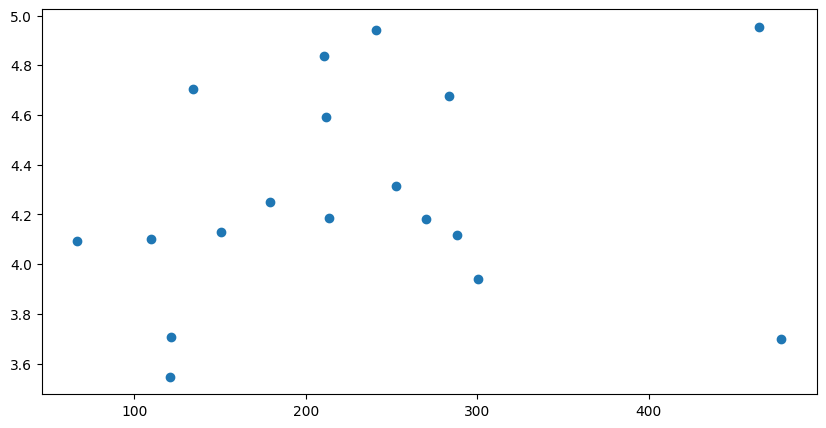

In [299]:

from matplotlib import pyplot as plt
import seaborn as sns        
fig, ax = plt.subplots(figsize=(10,5))
x = m
y = t[:-1]
ax.scatter(x,y)

In [300]:
import numpy as np
import scipy.stats
scipy.stats.pearsonr(x, y)

PearsonRResult(statistic=0.19523453600632082, pvalue=0.43753605674108353)

In [291]:
m.shape
#standardize m
m_s = (m-m.mean())/m.std()
p_m = (t[:-1]-t[:-1].mean())/t[:-1].std()

In [301]:
import numpy as np
import scipy.stats
scipy.stats.pearsonr(m_s, p_m)

PearsonRResult(statistic=0.19523453600632076, pvalue=0.43753605674108353)

In [296]:
#pearson correlation
np.corrcoef(m_s, p_m)[0,1]

0.19523453600632082

[Text(0, 0, '111'),
 Text(1, 0, '119'),
 Text(2, 0, '122'),
 Text(3, 0, '138'),
 Text(4, 0, '159'),
 Text(5, 0, '166'),
 Text(6, 0, '172'),
 Text(7, 0, '183'),
 Text(8, 0, '218'),
 Text(9, 0, '221'),
 Text(10, 0, '228'),
 Text(11, 0, '232'),
 Text(12, 0, '251'),
 Text(13, 0, '297'),
 Text(14, 0, '305'),
 Text(15, 0, '306'),
 Text(16, 0, '64'),
 Text(17, 0, '71')]

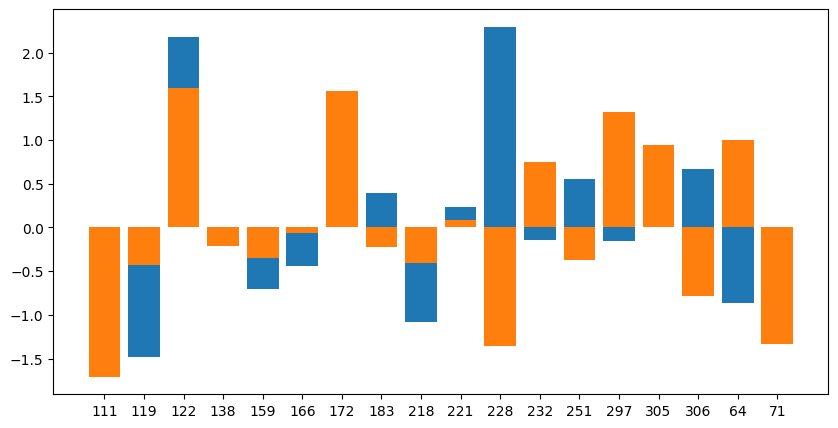

In [292]:
m=topic_distr.sum(0)
m = m[topic_ids]  
from matplotlib import pyplot as plt
import seaborn as sns        
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(np.arange(len(m)), m_s)
ax.bar(np.arange(len(m)), p_m)
# set x-axis ticks to be strings from topic_names
ax.set_xticks(np.arange(len(m)))
ax.set_xticklabels(topic_names)

In [279]:
np.array(performance.sum(0)[:-1]).shape

(18,)

In [272]:
#covariance
np.cov(m, performance.sum(0)[:-1])

array([[ 1.25689794e+04, -7.40979718e+00],
       [-7.40979718e+00,  1.13257134e+00]])

# vicuna evals

In [1]:

import argparse
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForCausalLM, LlamaTokenizer
import torch
import os
import ray
import sys
import json 
import time
import shortuuid
import numpy as np
import pandas as pd 
from tqdm import tqdm      
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt
from inst_follow.utils import gen_prompt, get_json_list,get_eval,parse_score,parse_score_with_expert

/anaconda/envs/comp_3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpnw8n_6q5
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpnw8n_6q5/_remote_module_non_scriptable.py


In [9]:
base_path="/home/v-oostapenko/dev/mttl/inst_follow/eval/table/review/"
alpaca_lora_path = base_path + "gpt35_vs_alpacalorafull7b4r_bygpt4.jsonl"
alpaca_topic_path = base_path + "gpt35_vs_alpacaloraatlas7b4rtopic_bygpt4.jsonl"
alpaca_average_path = base_path + "gpt35_vs_alpacaloraatlas7b4raverage_bygpt4.jsonl"

# alpaca_lora_path = base_path + "gpt35_vs_[old]alpacalorafull7b8r_bygpt4.jsonl"
# alpaca_topic_path = base_path + "gpt35_vs_[old]alpacaloraatlas7b4rtopic_bygpt4.jsonl"
# alpaca_average_path = base_path + "gpt35_vs_[old]alpacaloraatlas7b4raverage_bygpt4.jsonl"

In [10]:
with open(alpaca_lora_path, "r") as f:
    alora = [json.loads(line) for line in f.readlines()]
with open(alpaca_topic_path, "r") as f:
    atopic = [json.loads(line) for line in f.readlines()]
with open(alpaca_average_path, "r") as f:
    aaverage = [json.loads(line) for line in f.readlines()]

In [11]:
alora_scores = []
atopic_scores = []
aaverage_scores = []
for l, l1, l2 in zip(alora, atopic, aaverage):
    score = l["score"]
    score1 = l1["score"]
    score2 = l2["score"]
    if score!=[-1,-1] and score1!=[-1,-1] and score2!=[-1,-1]:
        alora_scores.append(score)
        atopic_scores.append(score1)
        aaverage_scores.append(score2)

In [12]:
len(alora_scores)

68

In [13]:
np.stack(alora_scores).sum(0)

array([559., 504.])

In [14]:
np.stack(atopic_scores).sum(0)

array([576. , 439.5])

In [16]:
np.stack(aaverage_scores).sum(0)

array([573., 462.])

### check NI evaluations

In [50]:
base = "/home/v-oostapenko/dev/mttl/inst_follow/eval/"
alpaca_o_shot_path = base + "ni/_chainyo_alpaca-lora-7bni-nshot0.jsonl"
alpaca_canonical_path = base + "ni/_chainyo_alpaca-lora-7bni-nshot_canonical.jsonl"

In [51]:
#load
with open(alpaca_o_shot_path, "r") as f:
    alpaca_o_shot = [json.loads(line) for line in f.readlines()]
with open(alpaca_canonical_path, "r") as f:
    alpaca_canonical = [json.loads(line) for line in f.readlines()]

In [41]:
cls_scores=[]
for l in alpaca_o_shot:
    if not isinstance(l, str):
        for n,s in l.items():
            # if "classification" in n:
                cls_scores.append(s)

In [55]:
np.mean(cls_scores)

25.017769747899155

In [52]:
cls_scores=[]
for l in alpaca_canonical:
    if not isinstance(l, str):
        for n,s in l.items():
            # if "classification" in n:
                cls_scores.append(s)

In [54]:
for i,l in enumerate(alpaca_canonical):
    if not isinstance(l, str):
        for n,s in l.items(): 
            assert s==cls_scores[i]
            print(s)

28.3318
0.1215
31.7294
44.4909
47.6911
28.8333
15.2082
2.3178
49.9638
16.6705
4.574
16.3932
47.0488
44.3919
70.889
1.1322
63.5915
17.8925
55.0
10.9869
4.8796
73.9494
3.3855
62.0606
26.3667
47.3637
52.0
24.0513
22.4921
39.1072
49.4109
57.78
34.0997
71.2885
6.6228
30.6549
61.9346
15.2762
86.0
0.0
22.9374
1.6721
0.9148
36.8842
30.1736
7.9706
5.7023
6.7132
4.4049
29.9479
0.0253
17.0616
14.4668
5.1099
1.4124
47.0
31.3317
6.6736
53.0
62.0261
4.1647
4.9541
0.1019
6.74
25.6837
59.0145
4.6504
16.3568
36.0
85.8084
22.1378
23.2181
0.3063
54.051
9.1597
9.9533
9.9796
1.9326
2.0813
43.0145
11.3651
27.1733
1.2502
12.4281
11.5127
30.2012
62.7099
9.1855
59.1967
6.8604
12.8625
16.1722
1.4438
3.1248
93.7142
0.5418
30.0
28.2965
9.486
17.0788
32.5425
3.7849
5.8713
28.9468
0.3157
20.5271
7.8647
17.7485
1.2781
38.2734
9.4286
0.5506
38.7639
1.9425
31.0262
4.2425
54.0081
62.6924
1.984


In [49]:
for l,l2 in zip(alpaca_canonical, alpaca_o_shot):
    assert l.keys()==l2.keys()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 for l,l2 in zip(alpaca_canonical, alpaca_o_shot):                                            │
│ ❱ 2 │   assert l.keys()==l2.keys()                                                               │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'str' object has no attribute 'keys'

In [42]:
len(cls_scores)

119

In [45]:
np.mean(cls_scores)

25.017769747899155

In [47]:
cls_scores

[28.3318,
 0.1215,
 31.7294,
 44.4909,
 47.6911,
 28.8333,
 15.2082,
 2.3178,
 49.9638,
 16.6705,
 4.574,
 16.3932,
 47.0488,
 44.3919,
 70.889,
 1.1322,
 63.5915,
 17.8925,
 55.0,
 10.9869,
 4.8796,
 73.9494,
 3.3855,
 62.0606,
 26.3667,
 47.3637,
 52.0,
 24.0513,
 22.4921,
 39.1072,
 49.4109,
 57.78,
 34.0997,
 71.2885,
 6.6228,
 30.6549,
 61.9346,
 15.2762,
 86.0,
 0.0,
 22.9374,
 1.6721,
 0.9148,
 36.8842,
 30.1736,
 7.9706,
 5.7023,
 6.7132,
 4.4049,
 29.9479,
 0.0253,
 17.0616,
 14.4668,
 5.1099,
 1.4124,
 47.0,
 31.3317,
 6.6736,
 53.0,
 62.0261,
 4.1647,
 4.9541,
 0.1019,
 6.74,
 25.6837,
 59.0145,
 4.6504,
 16.3568,
 36.0,
 85.8084,
 22.1378,
 23.2181,
 0.3063,
 54.051,
 9.1597,
 9.9533,
 9.9796,
 1.9326,
 2.0813,
 43.0145,
 11.3651,
 27.1733,
 1.2502,
 12.4281,
 11.5127,
 30.2012,
 62.7099,
 9.1855,
 59.1967,
 6.8604,
 12.8625,
 16.1722,
 1.4438,
 3.1248,
 93.7142,
 0.5418,
 30.0,
 28.2965,
 9.486,
 17.0788,
 32.5425,
 3.7849,
 5.8713,
 28.9468,
 0.3157,
 20.5271,
 7.8647,
 1